<a href="https://colab.research.google.com/github/unt-iialab/INFO5731_Spring2020/blob/master/Assignments/INFO5731_Assignment_Four.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment Four**

In this assignment, you are required to conduct topic modeling, sentiment analysis based on **the dataset you created from assignment three**.

# **Question 1: Topic Modeling**

(30 points). This question is designed to help you develop a feel for the way topic modeling works, the connection to the human meanings of documents. Based on the dataset from assignment three, write a python program to **identify the top 10 topics in the dataset**. Before answering this question, please review the materials in lesson 8, especially the code for LDA, LSA, and BERTopic. The following information should be reported:

(1) Features (text representation) used for topic modeling.

(2) Top 10 clusters for topic modeling.

(3) Summarize and describe the topic for each cluster. 


In [4]:
# Write your code here
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 999





In [2]:
df = pd.read_csv("datafile.csv")
df.head()

,document_id,clean_text,sentiment
0,1,ukraine stand white supremacy russia stand,Neutral
1,2,remember racism black people problem way white...,Negative
2,3,born slavery tubman escaped made mission rescu...,Positive
3,4,kill body take life never kill soul soul live ...,Positive
4,5,america need label kkk proud boy neo nazi hate...,Neutral


In [3]:
data = df.iloc[:, 1]
data.head()

0           ukraine stand white supremacy russia stand
1    remember racism black people problem way white...
2    born slavery tubman escaped made mission rescu...
3    kill body take life never kill soul soul live ...
4    america need label kkk proud boy neo nazi hate...
Name: clean_text, dtype: object

In [5]:
# for Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# lemmatization
import spacy
# To Plot tools
import pyLDAvis
import pyLDAvis.gensim_models
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nimis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#To convert sentences to words
def sentences_to_words(sentences):
    for sent in sentences:
        yield(gensim.utils.simple_preprocess(str(sent), deacc=True))  # deacc=True removes punctuations

data_words = list(sentences_to_words(data))


In [12]:
#1 Building the bigram and trigram models for given
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)#high threshold
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
# making sentence fast and get a sentence joined as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
# trigram ex
print(trigram_mod[bigram_mod[data_words[0]]])


['ukraine', 'stand', 'white', 'supremacy', 'russia', 'stand']


In [13]:
# Defining functions for stopwords, bigrams, trigrams  lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    t_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        t_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return t_out


In [14]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['stand', 'white', 'stand']]


In [15]:
# Create Dictionary
id2word_words = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts_1 = data_lemmatized

# Term Document Frequency
corpus = [id2word_words.doc2bow(text) for text in texts_1]

# View
print(corpus[:1])


[[(0, 2), (1, 1)]]


In [16]:
# Or, you can see a human-readable form of the corpus itself.
# Human readable format of corpus (term-frequency)
[[(id2word_words[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('stand', 2), ('white', 1)]]

In [20]:
#2 Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word_words,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [21]:
# Print the Keyword in the 10 topics
from pprint import pprint
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.066*"say" + 0.039*"today" + 0.035*"day" + 0.032*"history" + 0.028*"never" '
  '+ 0.020*"woman" + 0.019*"verdict" + 0.018*"post" + 0.016*"world" + '
  '0.016*"change"'),
 (1,
  '0.028*"use" + 0.027*"come" + 0.027*"video" + 0.027*"think" + 0.026*"case" + '
  '0.020*"human" + 0.019*"look" + 0.015*"money" + 0.014*"follow" + '
  '0.014*"activist"'),
 (2,
  '0.155*"amp" + 0.096*"ding" + 0.061*"de" + 0.045*"good" + 0.029*"love" + '
  '0.026*"see" + 0.016*"story" + 0.016*"great" + 0.014*"long" + 0.013*"win"'),
 (3,
  '0.041*"crime" + 0.037*"white" + 0.036*"time" + 0.034*"right" + '
  '0.033*"support" + 0.032*"found_guilty" + 0.031*"federal_hate" + '
  '0.018*"need" + 0.016*"protest" + 0.015*"help"'),
 (4,
  '0.035*"let" + 0.026*"movement" + 0.024*"try" + 0.024*"thing" + 0.023*"even" '
  '+ 0.023*"history_month" + 0.023*"enough" + 0.019*"color" + 0.014*"believe" '
  '+ 0.013*"other"'),
 (5,
  '0.077*"new" + 0.053*"call" + 0.045*"get" + 0.044*"man" + '
  '0.044*"spirituality" + 0.044*"

In [14]:
#3
'''TOPIC 1: Regarding the videos showing the struggle that the victim was going through.
TOPIC 2: About black people and their supremacy. 
TOPIC 3: Working and learning together to stop racial injustice. 
TOPIC 4: Regarding the polices being racists.
TOPIC 5: Regarding the racial crimes.
TOPIC 6: Regarding the pain and guilt felt by the families.
TOPIC 7: Regarding the black lives matter movement. 
TOPIC 8: Regarding love, peace and support. 
TOPIC 9: Regarding racial injustice.
TOPIC 10: Regarding justic for who were targeted for hate crime.
'''

'TOPIC 1: Regarding the videos showing the struggle that the victim was going through.\nTOPIC 2: About black people and their supremacy. \nTOPIC 3: Working and learning together to stop racial injustice. \nTOPIC 4: Regarding the polices being racists.\nTOPIC 5: Regarding the racial crimes.\nTOPIC 6: Regarding the pain and guilt felt by the families.\nTOPIC 7: Regarding the black lives matter movement. \nTOPIC 8: Regarding love, peace and support. \nTOPIC 9: Regarding racial injustice.\nTOPIC 10: Regarding justic for who were targeted for hate crime.\n'

# **Question 2: Sentiment Analysis**

(30 points). Sentiment analysis also known as opinion mining is a sub field within Natural Language Processing (NLP) that builds machine learning algorithms to classify a text according to the sentimental polarities of opinions it contains, e.g., positive, negative, neutral. The purpose of this question is to develop a machine learning classifier for sentiment analysis. Based on the dataset from assignment three, write a python program to implement a sentiment classifier and evaluate its performance. Notice: **80% data for training and 20% data for testing**.  

(1) Features used for sentiment classification and explain why you select these features.

(2) Select two of the supervised learning algorithm from scikit-learn library: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning, to build a sentiment classifier respectively. Note: Cross-validation (5-fold or 10-fold) should be conducted. Here is the reference of cross-validation: https://scikit-learn.org/stable/modules/cross_validation.html.

(3) Compare the performance over accuracy, precision, recall, and F1 score for the two algorithms you selected. Here is the reference of how to calculate these metrics: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9. 

In [1]:
#1
'''I utilized the TF-IDF vectorizer to extract features from my data corpus since it provides information on the relevance of the words in addition to their frequency, which I believe gives the words more weight when analyzing the various classes and enhancing the precision of our model.'''

'I utilized the TF-IDF vectorizer to extract features from my data corpus since it provides information on the relevance of the words in addition to their frequency, which I believe gives the words more weight when analyzing the various classes and enhancing the precision of our model.'

In [4]:
data = pd.read_csv("datafile.csv")
data.head()


,document_id,clean_text,sentiment
0,1,ukraine stand white supremacy russia stand,Neutral
1,2,remember racism black people problem way white...,Negative
2,3,born slavery tubman escaped made mission rescu...,Positive
3,4,kill body take life never kill soul soul live ...,Positive
4,5,america need label kkk proud boy neo nazi hate...,Neutral


In [5]:
#Tf-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
p = tfidf_vectorizer.fit_transform(data['clean_text'].apply(lambda p: np.str_(p)))
q = data['sentiment']


In [6]:
from sklearn.model_selection import train_test_split

p_train, p_test, q_train, q_test = train_test_split(p,q,test_size = 0.2, random_state = 202)

print ("p_train", p_train.shape)
print ("p_test", p_test.shape)
print ("q_train", q_train.shape)
print ("q_test", q_test.shape)


p_train (1840, 5015)
p_test (460, 5015)
q_train (1840,)
q_test (460,)


In [7]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(p_train,q_train)
predictions_nb = nb.predict(p_test)
predictions_nb


array(['Neutral', 'Neutral', 'Neutral', 'Negative', 'Negative', 'Neutral',
       'Negative', 'Neutral', 'Positive', 'Neutral', 'Positive',
       'Positive', 'Neutral', 'Neutral', 'Positive', 'Negative',
       'Positive', 'Neutral', 'Positive', 'Neutral', 'Negative',
       'Positive', 'Positive', 'Negative', 'Neutral', 'Negative',
       'Positive', 'Negative', 'Negative', 'Positive', 'Positive',
       'Neutral', 'Neutral', 'Positive', 'Neutral', 'Negative',
       'Negative', 'Neutral', 'Neutral', 'Negative', 'Negative',
       'Neutral', 'Positive', 'Neutral', 'Negative', 'Neutral',
       'Positive', 'Negative', 'Neutral', 'Positive', 'Positive',
       'Neutral', 'Negative', 'Negative', 'Neutral', 'Neutral',
       'Positive', 'Neutral', 'Negative', 'Neutral', 'Negative',
       'Neutral', 'Positive', 'Positive', 'Negative', 'Positive',
       'Neutral', 'Neutral', 'Negative', 'Positive', 'Neutral',
       'Negative', 'Neutral', 'Neutral', 'Neutral', 'Positive',
       'Negativ

In [9]:
from sklearn.metrics import classification_report

c = classification_report(q_test, predictions_nb)
print("Classification Report: ", "\n", "\n",c)


Classification Report:  
 
               precision    recall  f1-score   support

    Negative       0.71      0.77      0.74       150
     Neutral       0.75      0.63      0.68       161
    Positive       0.69      0.74      0.71       149

    accuracy                           0.71       460
   macro avg       0.72      0.72      0.71       460
weighted avg       0.72      0.71      0.71       460



In [19]:
from sklearn.model_selection import cross_val_score
accuracies_nb = cross_val_score(estimator = nb, P = p_train, Q = q_train, cv = 10)

print(f" The Accuracy for Naive Bayes Model is :  {round(accuracies_nb.mean()*100)}%")

Accuracy of the Naive Bayes Model is :  72%


In [11]:
#svm
from sklearn import svm

t = svm.SVC(kernel='linear')
t.fit(p_train, q_train)
predictions_svm = t.predict(p_test)
predictions_svm

array(['Neutral', 'Neutral', 'Neutral', 'Neutral', 'Negative', 'Neutral',
       'Negative', 'Neutral', 'Neutral', 'Neutral', 'Positive',
       'Positive', 'Neutral', 'Neutral', 'Positive', 'Negative',
       'Positive', 'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral',
       'Positive', 'Neutral', 'Neutral', 'Negative', 'Positive',
       'Negative', 'Negative', 'Positive', 'Positive', 'Neutral',
       'Neutral', 'Positive', 'Neutral', 'Neutral', 'Negative', 'Neutral',
       'Neutral', 'Negative', 'Neutral', 'Neutral', 'Positive', 'Neutral',
       'Negative', 'Neutral', 'Positive', 'Negative', 'Neutral',
       'Positive', 'Positive', 'Neutral', 'Negative', 'Negative',
       'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral', 'Neutral',
       'Negative', 'Neutral', 'Positive', 'Positive', 'Negative',
       'Positive', 'Neutral', 'Neutral', 'Negative', 'Positive',
       'Neutral', 'Positive', 'Neutral', 'Neutral', 'Neutral', 'Positive',
       'Neutral', 'Neutral', 'N

In [12]:
cr_svm = classification_report(q_test, predictions_svm)
print("Classification Report: ", "\n", "\n",cr_svm)

Classification Report:  
 
               precision    recall  f1-score   support

    Negative       0.88      0.70      0.78       150
     Neutral       0.68      0.88      0.77       161
    Positive       0.79      0.69      0.74       149

    accuracy                           0.76       460
   macro avg       0.78      0.76      0.76       460
weighted avg       0.78      0.76      0.76       460



In [ ]:
from sklearn.model_selection import cross_val_score
accuracies_svm = cross_val_score(estimator = t, P = p_train, Q = q_train, cv = 10)

print(f"Accuracy of the SVM Model is :  {round(accuracies_svm.mean()*100)}%")

In [15]:
#3
'''The accuracy of the SVM model after 10-fold cross validation is 79% as opposed to 72% for the Naive Bayes model. This shows that the SVM model outperforms the naive bayes model when it comes to categorizing tweets into discrete categories.'''

'The accuracy of the SVM model after 10-fold cross validation is 79% as opposed to 72% for the Naive Bayes model. This shows that the SVM model outperforms the naive bayes model when it comes to categorizing tweets into discrete categories.'

# **Question 3: House price prediction**

(40 points). You are required to build a **regression** model to predict the house price with 79 explanatory variables describing (almost) every aspect of residential homes. The purpose of this question is to practice regression analysis, an supervised learning model. The training data, testing data, and data description files can be download from canvas. Here is an axample for implementation: https://towardsdatascience.com/linear-regression-in-python-predict-the-bay-areas-home-price-5c91c8378878. 


In [5]:
train_data = pd.read_csv("train.csv")
train_data.head()


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
test_data = pd.read_csv("test.csv")
test_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [8]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [11]:
train_data.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [12]:
#to divide the data into numerical, categorical.

train_categorical_data = [var for var in train_data.columns if train_data[var].dtype=='O']
train_numerical_data = [var for var in train_data.columns if train_data[var].dtype=='float']

In [13]:
# imputing the missing values by the attributes mean for all the numerical attributes.

for h in train_numerical_data:
    train_data[h].fillna(value = train_data[h].mean(),inplace = True)


In [14]:
train_data.isnull().sum()


Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 81, dtype: int64

In [15]:
test_data.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           4
LotFrontage      227
LotArea            0
                ... 
MiscVal            0
MoSold             0
YrSold             0
SaleType           1
SaleCondition      0
Length: 80, dtype: int64

In [16]:
#Dividing the data into numerical and categorical.

test_categorical_data = [var for var in test_data.columns if test_data[var].dtype=='O']
test_numerical_data = [var for var in test_data.columns if test_data[var].dtype=='float']

In [17]:
# imputing the missing values by the attributes mean for all the numerical attributes.

for h in test_numerical_data:
    test_data[h].fillna(value = test_data[h].mean(),inplace = True)

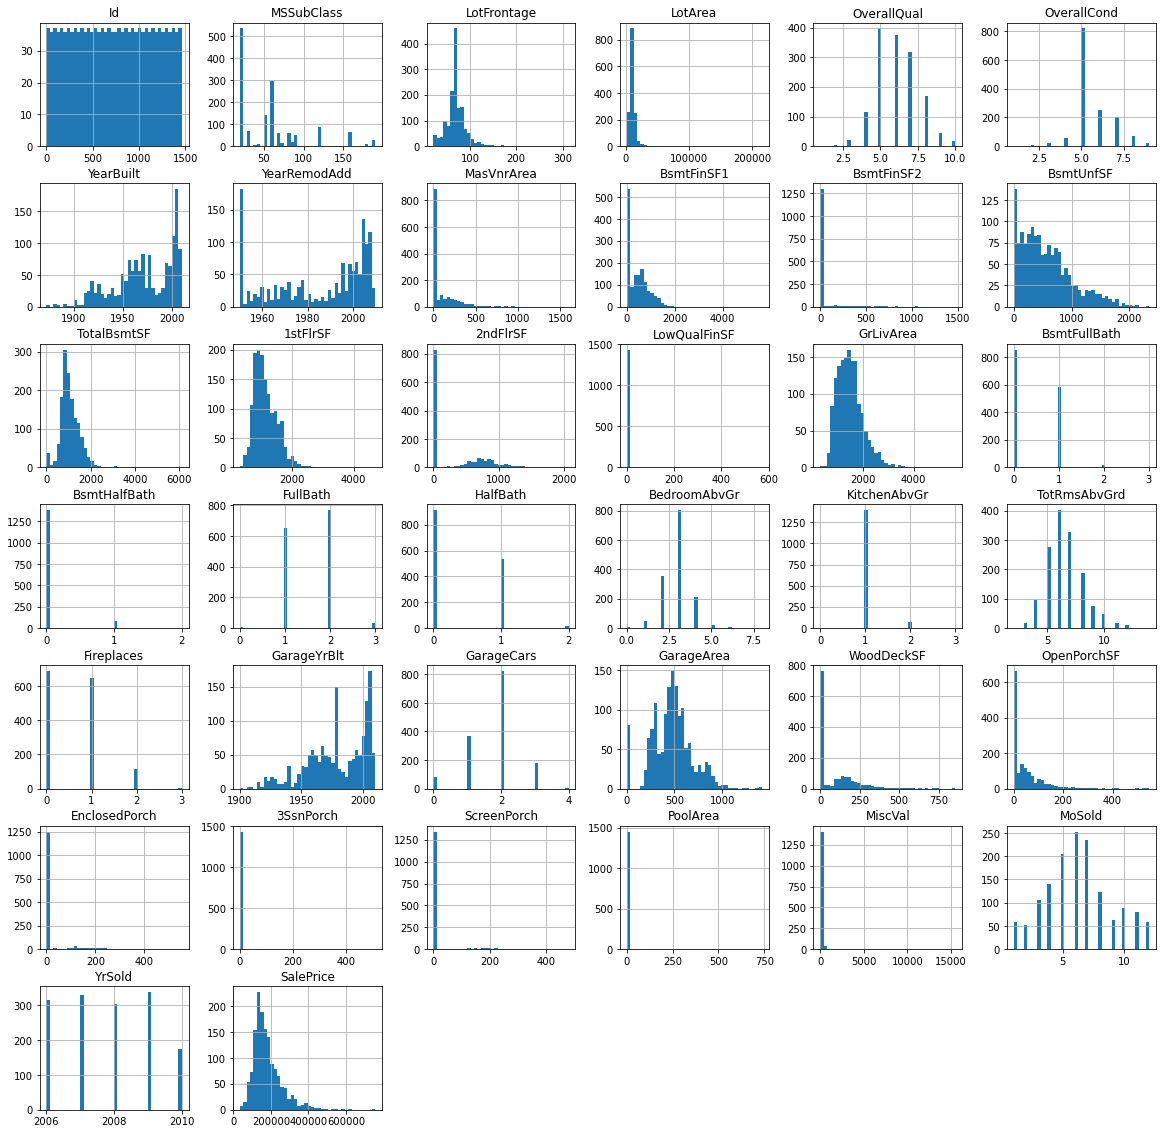

In [18]:
#EDA
train_data.hist(bins=40, figsize=(20,20))
plt.show()


array([[<AxesSubplot:xlabel='SalePrice', ylabel='SalePrice'>,
        <AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>,
        <AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>,
        <AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>,
        <AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>,
        <AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>,
        <AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>,
        <AxesSubplot:xlabel='FullBath', ylabel='SalePrice'>,
        <AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>],
       [<AxesSubplot:xlabel='SalePrice', ylabel='OverallQual'>,
        <AxesSubplot:xlabel='OverallQual', ylabel='OverallQual'>,
        <AxesSubplot:xlabel='GrLivArea', ylabel='OverallQual'>,
        <AxesSubplot:xlabel='GarageCars', ylabel='OverallQual'>,
        <AxesSubplot:xlabel='GarageArea', ylabel='OverallQual'>,
        <AxesSubplot:xlabel='TotalBsmtSF', ylabel='OverallQual'>,
        <AxesSubplot:xlabel='1stFlrSF', ylabel=

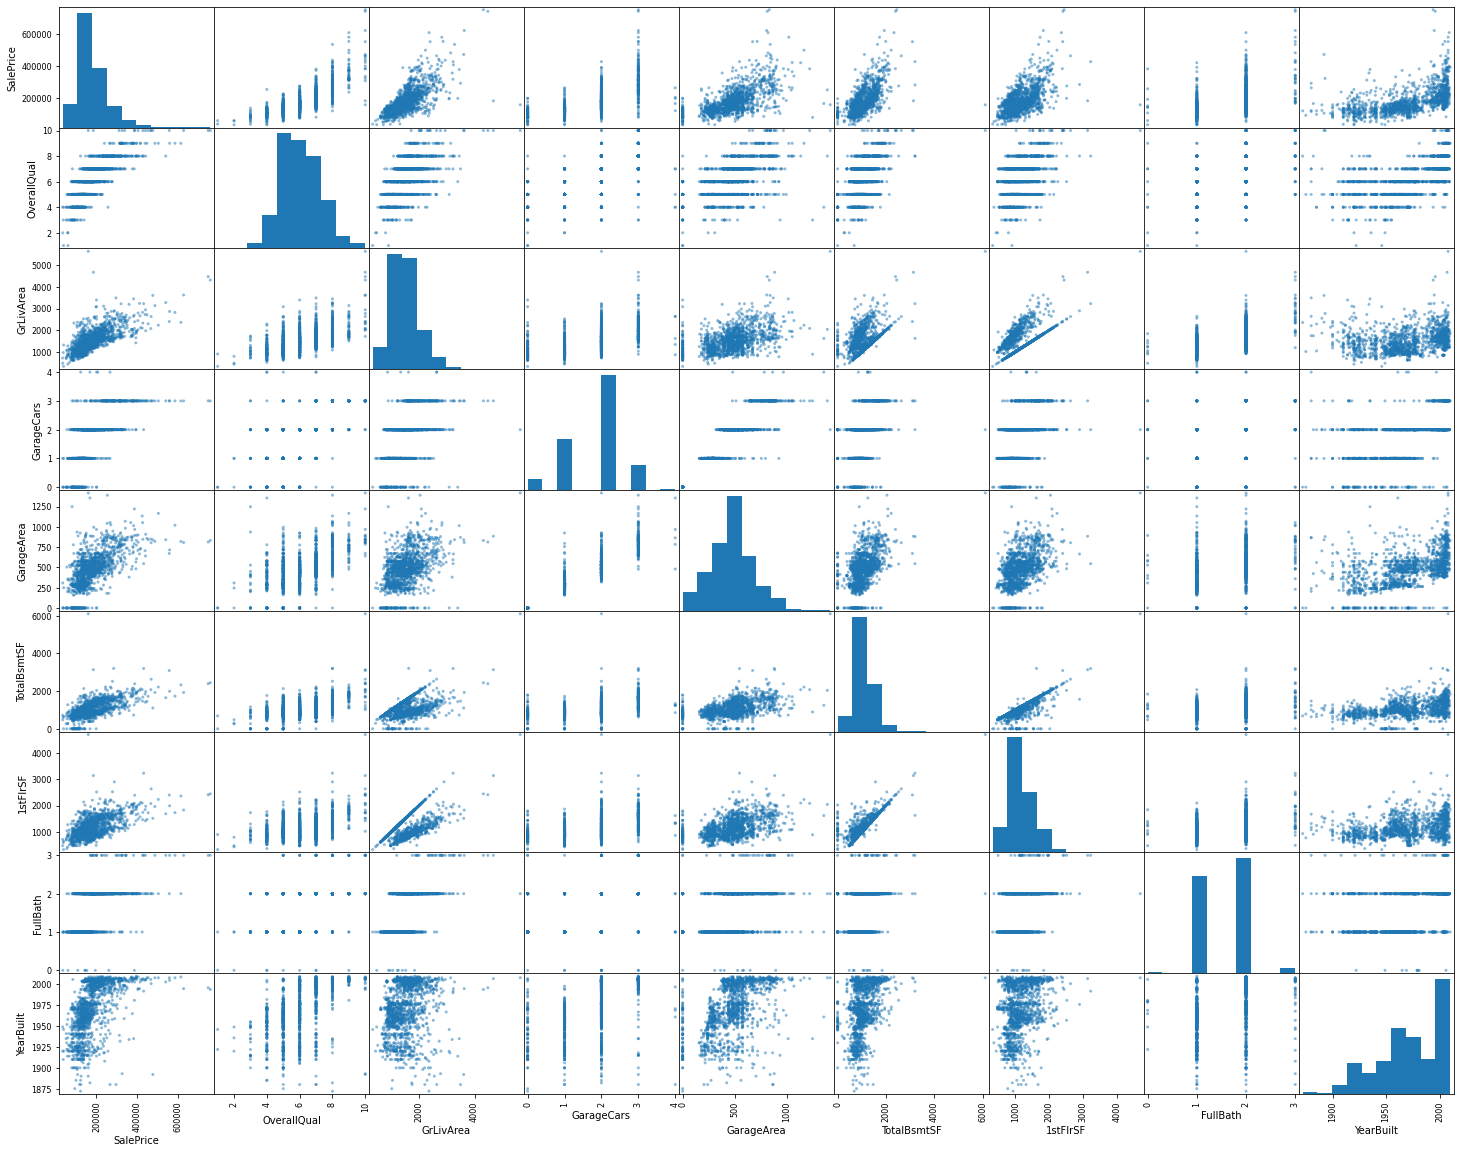

In [19]:
from pandas.plotting import scatter_matrix
att = ["SalePrice", "OverallQual", "GrLivArea", "GarageCars", "GarageArea","TotalBsmtSF","1stFlrSF", "FullBath","YearBuilt" ]
scatter_matrix(train_data[att], figsize=(25, 20))


<AxesSubplot:>

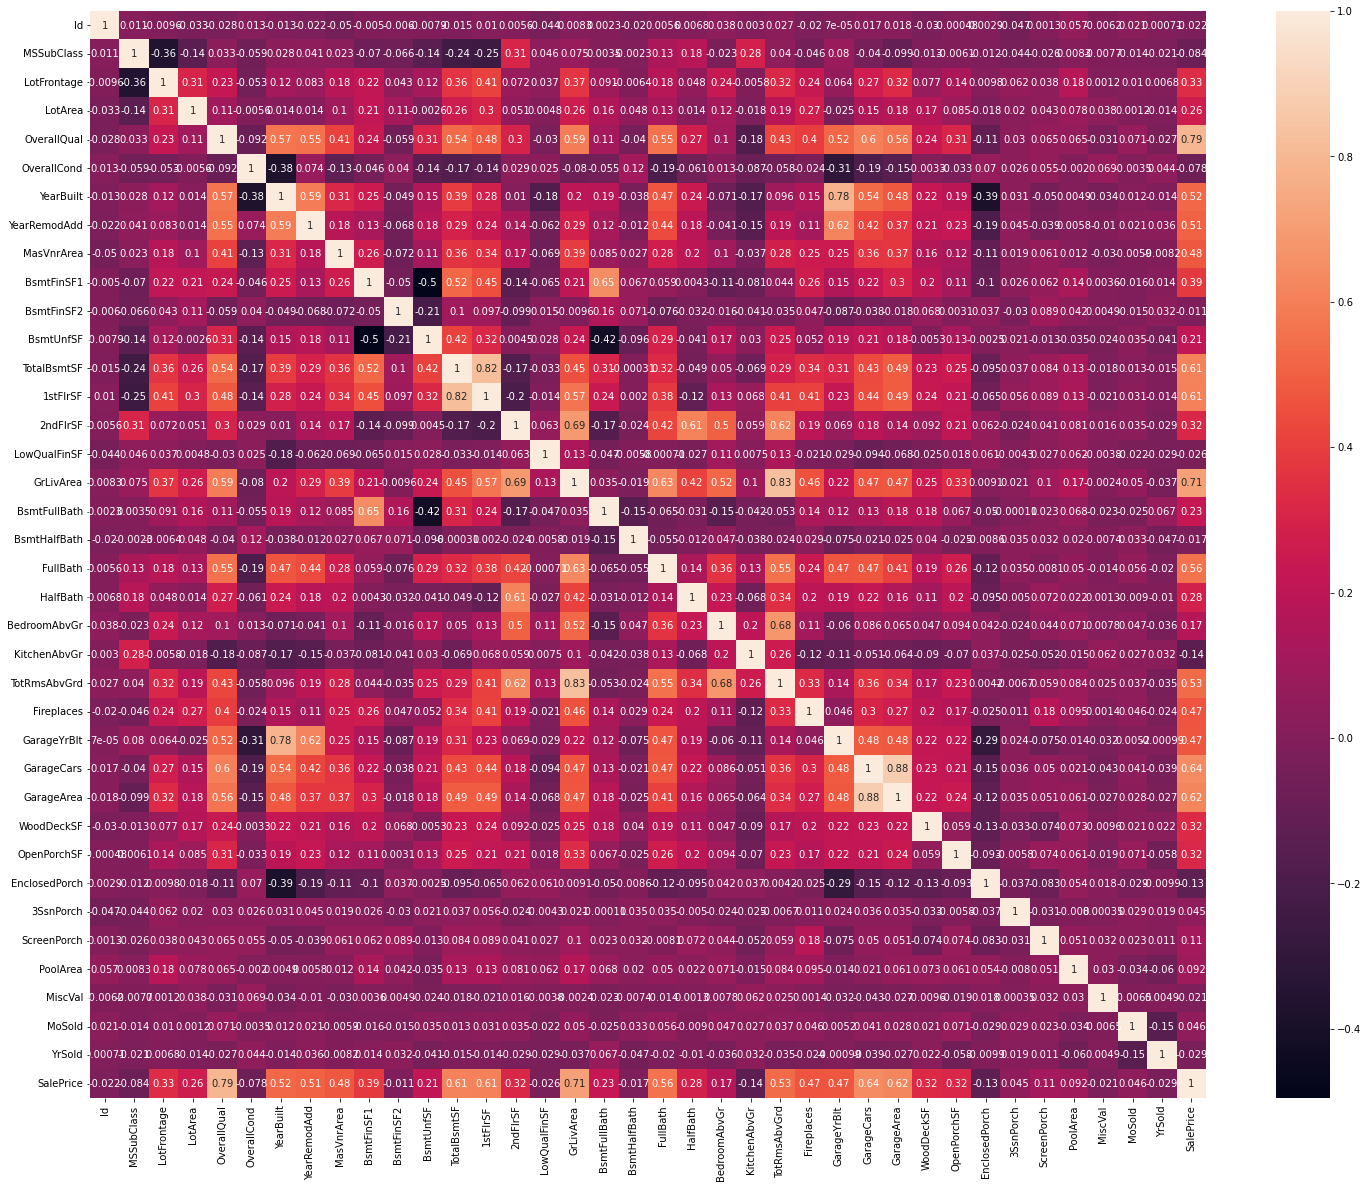

In [20]:
#correlation analysis
plt.figure(figsize = (25,20))
sns.heatmap(train_data.corr(), annot = True)

In [21]:
cmatrix = train_data.corr().abs()
upper_tri = cmatrix.where(np.triu(np.ones(cmatrix.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.80)]
print("The attributes that needs to be dropped are:\n ",to_drop)

The attributes that needs to be dropped are:
  ['1stFlrSF', 'TotRmsAbvGrd', 'GarageArea']


In [22]:
train_data.drop(columns = to_drop, axis = 1, inplace = True)
test_data.drop(columns = to_drop, axis = 1, inplace = True)
# dropping id attributes
train_data.drop(labels = ['Id'], axis = 1, inplace = True)
test_data.drop(labels = ['Id'], axis = 1, inplace = True)

In [23]:
from sklearn.preprocessing import LabelEncoder

for column in train_data.columns:
    encoder = LabelEncoder()
    encoder.fit(list(train_data[column].values))
    train_data[column] = encoder.transform(list(train_data[column].values))

In [24]:
for column in test_data.columns:
    encoder_test = LabelEncoder()
    encoder_test.fit(list(test_data[column].values))
    test_data[column] = encoder_test.transform(list(test_data[column].values))



In [25]:
p_train = train_data.iloc[:,:-1]
q_train = train_data.iloc[:,-1]
p_test = test_data.iloc[:,:]


In [26]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(p_train, q_train)
predictions_lr = lin_reg.predict(p_test)


In [27]:
print("R-Square value: ", lin_reg.score(p_train,q_train))

R-Square value:  0.9174185321709603


In [28]:
pd.DataFrame({'Predicted House Price Values': predictions_lr})



,Predicted House Price Values
0,70.343583
1,212.796788
2,304.151060
3,340.491565
4,285.537547
...,...
1454,-24.296071
1455,-58.125625
1456,249.645948
1457,78.572121
